In [48]:
import jax.numpy as jnp
import networkx as nx
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BI import bi
m = bi(platform='cpu')

jax.local_device_count 32


# Data simulation

# Multivariate Gaussian Mixture Model (GMM)

In [49]:

import numpyro
import numpyro.distributions as dists
import jax
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.ops.indexing import Vindex
import numpy as np

m = bi(platform='cpu')
def simData(n = 100, dim = 2, k = 3, p_real = [0.1, 0.5, 0.4], mus = [[10,10], [5,5], [1,1]], sigmas = [1,0.5], seed = 0):
    """
    Simulate data from a mixture of Gaussians.
    
    Parameters
    ----------
    n : int
        Number of samples.
    dim : int
        Dimensionality of the data.
    k : int
        Number of mixture components.
    p_real : array-like, shape (k,)
        Probability of each mixture component.
    sigma : array-like, shape (dim,)
        Standard deviation of the noise.
    mus : array-like, shape (k, dim)
        Means of the mixture components on each dimension.
    sigmas : array-like, shape (k,)
        Standard deviations of the mixture components on each groups.
        
    Returns
    -------
    data : array-like, shape (n, dim)
        Simulated data.
        
    """
    key = jax.random.key(seed)
    seeds = jax.random.randint(key, (100,), 0, 10000)

    mus = jnp.array(mus)
    sigmas = jnp.array(sigmas)
    p_real = jnp.array(p_real)    

    clusters = m.dist.categorical(probs = p_real, sample = True, shape=(n,))
    s_clusters = sigmas[clusters]
    m_clusters = mus[clusters]
    
    return jax.vmap(lambda x, y, z  : m.dist.multivariatenormal(x, jnp.diag(jnp.repeat(y, dim)), sample = True, seed = z))(m_clusters, s_clusters, seeds), clusters

def plot_synthetic_data(X, true_labels):
    import matplotlib.pyplot as plt

    visits = X[:, 0]
    assoc_prop = X[:, 1]

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(visits, assoc_prop, c=true_labels, cmap='viridis', s=50, alpha=0.7)
    plt.colorbar(scatter, label="True Cluster Labels")
    plt.xlabel("Visits")
    plt.ylabel("Association Proportion")
    plt.title("Scatter Plot of Visits vs. Association Proportion, Colored by True Labels")
    plt.show()


jax.local_device_count 32


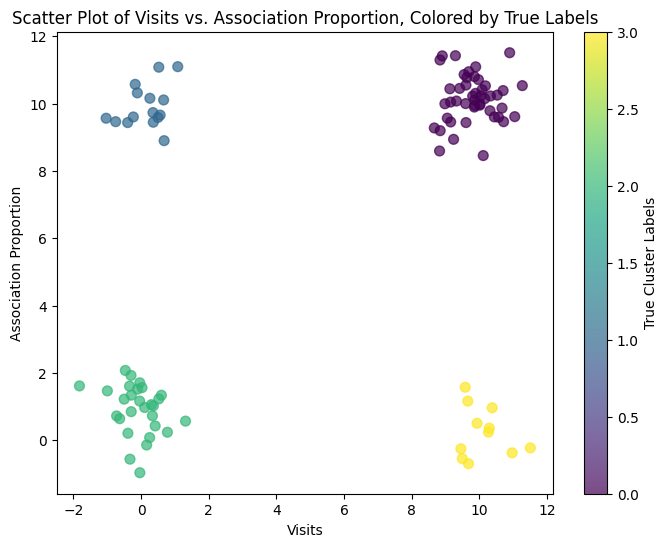

In [50]:
data, true_labels =  simData(n = 100, dim = 2, k = 4, 
p_real = [0.50, 0.10, 0.30, 0.10], 
mus = [[10,10], [0,10], [0,1] , [10,0]], 
sigmas = [0.5,0.5, 0.5,0.5])
plot_synthetic_data(data, true_labels)

#  BI

In [52]:
from numpyro.ops.indexing import Vindex
import jax
weight = 0.5
K = 4
def model(data = data, weight = 0.5, K = 4):

    N, dim = data.shape
    cluster_proba = m.dist.dirichlet(weight * jnp.ones(K), name = 'cluster_proba')
     
    
    locs = m.dist.multivariatenormal(jnp.zeros(dim), 10*jnp.eye(dim), name= 'locs', shape = (K, dim))
    sigma = m.dist.halfcauchy(scale=10, name = 'sigma', shape = (K, dim))  
    
    with numpyro.plate('data', N):
        assignment = numpyro.deterministic('assignments', m.dist.categorical(cluster_proba, name='assignment'))
        sigma_expanded = jnp.expand_dims(sigma[assignment], -1) * jnp.eye(dim)
        #sigma_expanded = sigma[assignment][1]*jnp.eye(dim)
        print(sigma_expanded.shape)
        LOC = Vindex(locs)[assignment]
        print(LOC.shape)
        m.dist.multivariatenormal(LOC,sigma_expanded, obs = data)


m = bi(platform='cpu')
m.run(model)
#m.summary()



jax.local_device_count 32
(100, 2, 2)
(100, 2, 2)


ValueError: Incompatible shapes for broadcasting: shapes=[(), (100, 2, 2, 1), (100, 2, 2)]

# Numpyro working but sigma of one dimention only

In [110]:
import numpyro.distributions as dists
from numpyro.ops.indexing import Vindex
def model(K, data=None, weight = 1):
    N, dim = data.shape
    cluster_proba = numpyro.sample('cluster_proba', dists.Dirichlet(weight * jnp.ones(K)))
    

    with numpyro.plate('components', K, dim= -1 ):
        locs = numpyro.sample('locs', dists.MultivariateNormal(jnp.zeros(dim), 10 * jnp.eye(dim)))
        sigma = numpyro.sample('sigma', dists.HalfCauchy(scale=10)) # TODO: Need to set up a different sigma for each axes.!!!!!!!!!!!!!!!!

    with numpyro.plate('data', N):
        assignment = numpyro.sample('assignment', dists.Categorical(cluster_proba), infer={"enumerate": "parallel"})
        
        # Correctly broadcast sigma to create covariance matrices
        sigma_expanded = Vindex(sigma)[assignment][..., None, None] * jnp.eye(dim)
        
        numpyro.sample('obs',  dists.MultivariateNormal(Vindex(locs)[assignment], sigma_expanded), obs=data)


m.data_on_model = {'data':data, 'K':4}
m.run(model, num_warmup=1000, num_samples=1000, seed= 5)
m.sampler.print_summary() #p_real = [0.50, 0.10, 0.30, 0.10],

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1211.58it/s, 7 steps of size 5.95e-01. acc. prob=0.88]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
cluster_proba[0]      0.28      0.05      0.28      0.21      0.35   2232.74      1.00
cluster_proba[1]      0.45      0.05      0.45      0.36      0.52   3182.63      1.00
cluster_proba[2]      0.15      0.04      0.15      0.09      0.21   2622.27      1.00
cluster_proba[3]      0.12      0.03      0.11      0.06      0.16   1945.96      1.00
       locs[0,0]     -0.07      0.13     -0.07     -0.28      0.13   2116.81      1.00
       locs[0,1]      0.90      0.14      0.91      0.70      1.12   1871.40      1.00
       locs[1,0]      9.81      0.09      9.80      9.66      9.97   3358.78      1.00
       locs[1,1]     10.13      0.10     10.12      9.98     10.31   1785.41      1.00
       locs[2,0]      0.16      0.17      0.17     -0.11      0.43   1853.79      1.00
       locs[2,1]      9.88      0.18      9.89      9.58     10.15   1652.86      1.00
       locs[3,0]     10.06      0.24     1

In [ ]:
K=4
posterior_samples = m.sampler.get_samples()
predictive =Predictive(model, posterior_samples)
predictions = predictive(jax.random.PRNGKey(1), data=data, K=K)
pred_clusters = predictions['assignment']


In [ ]:
for i in range(pred_clusters.shape[0]):
    plt.hist(pred_clusters[i,:])
    plt.show()

In [120]:
from functools import partial

@partial(jax.jit, static_argnums=1)
def clusters_asignation(X,max_clusters = 10):
    l = X.shape[0]
    clusters, counts = jnp.unique(X, return_counts=True, size=max_clusters)
    perc = counts / l
    max_idx = jnp.argmax(perc)
    return perc[max_idx], clusters[max_idx]

def cluster_proba(pred_clusters):
    perc, grp = jax.vmap(clusters_asignation, in_axes=1)(pred_clusters)
    return grp  # If you only need percentages
cluster_proba(pred_clusters)

Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [ ]:
#cluster_probs = jnp.mean(jax.nn.one_hot(predicted_assignments, K), axis=0)
cluster_probs = jax.vmap(lambda x: cluster_proba(x), in_axes = 0)(pred_clusters.T)

# Get most likely cluster for each point
final_assignments = jnp.argmax(cluster_probs, axis=1)
final_assignments

In [ ]:
#cluster_probs = jnp.mean(jax.nn.one_hot(predicted_assignments, K), axis=0)
cluster_probs = vmap(lambda x: cat_probs(x), in_axes = 0)(pred_clusters.T)

# Get most likely cluster for each point
final_assignments = jnp.argmax(cluster_probs, axis=1)
final_assignments

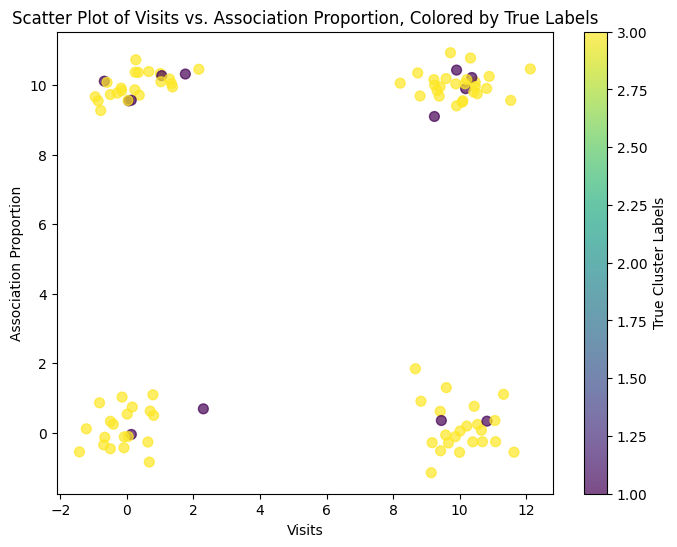

[[25.1 26.2 20.7 28. ]
 [22.3 28.1 21.8 27.8]
 [23.5 25.9 19.1 31.5]
 [21.4 26.2 25.  27.4]
 [25.  24.3 21.7 29. ]
 [24.2 26.7 20.9 28.2]
 [21.3 26.  22.5 30.2]
 [24.3 24.4 23.5 27.8]
 [23.  27.3 22.7 27. ]
 [23.8 27.2 22.  27. ]
 [23.4 26.6 20.7 29.3]
 [21.8 26.  23.7 28.5]
 [23.5 26.2 20.4 29.9]
 [22.4 24.3 21.3 32. ]
 [25.4 24.8 19.5 30.3]
 [21.9 25.8 21.3 31. ]
 [24.1 25.8 24.  26.1]
 [23.7 26.6 19.5 30.2]
 [23.3 29.5 21.3 25.9]
 [23.3 25.9 20.4 30.4]
 [23.9 26.6 20.1 29.4]
 [22.7 26.8 21.2 29.3]
 [23.4 27.2 20.6 28.8]
 [24.2 25.  21.5 29.3]
 [23.6 26.5 22.  27.9]
 [25.7 25.  20.2 29.1]
 [22.1 26.9 21.5 29.5]
 [22.5 30.  20.1 27.4]
 [24.5 28.1 20.5 26.9]
 [25.2 26.2 21.1 27.5]
 [23.4 27.3 21.3 28. ]
 [23.4 25.8 20.1 30.7]
 [24.6 25.2 22.  28.2]
 [22.4 25.3 23.4 28.9]
 [22.7 25.3 19.4 32.6]
 [24.8 27.7 19.5 28. ]
 [24.1 25.  22.2 28.7]
 [23.5 26.8 21.7 28. ]
 [24.5 27.4 20.8 27.3]
 [22.4 27.  23.4 27.2]
 [23.2 25.7 21.9 29.2]
 [22.9 26.9 23.1 27.1]
 [23.8 26.6 22.  27.6]
 [25.  26.6

In [9]:
import matplotlib.pyplot as plt
def cat_probs(tmp, max_category = 4):
    counts = jnp.bincount(tmp, length=max_category)  # Count occurrences of each category
    percentages = (counts / tmp.size) * 100
    return percentages

def analyze(sampler, data,  K=4):
    # Get posterior samples
    posterior_samples = sampler.get_samples()

    # Use Predictive to get cluster assignments
    predictive = Predictive(model, posterior_samples)
    predictions = predictive(jax.random.PRNGKey(1), data=data, K=K)
    predicted_assignments = predictions['assignment']

    # Calculate cluster probabilities
    #cluster_probs = jnp.mean(jax.nn.one_hot(predicted_assignments, K), axis=0)
    cluster_probs = vmap(lambda x: cat_probs(x), in_axes = 0)(predicted_assignments.T)
    
    # Get most likely cluster for each point
    final_assignments = jnp.argmax(cluster_probs, axis=1)

    plot_synthetic_data(data, final_assignments)
    
    # Calculate uncertainty
    assignment_uncertainty = 1 - jnp.max(cluster_probs, axis=1)
    print(cluster_probs)
    print("\nMean assignment uncertainty:", jnp.mean(assignment_uncertainty))

analyze(m.sampler, data, K=4)

# https://luiarthur.github.io/TuringBnpBenchmarks/dpsbgmm

In [134]:
# Stick break function
def stickbreak(v):
    batch_ndims = len(v.shape) - 1
    cumprod_one_minus_v = jnp.exp(jnp.log1p(-v).cumsum(-1))
    # cumprod_one_minus_v = np.cumprod(1-v, axis=-1)
    one_v = jnp.pad(v, [[0, 0]] * batch_ndims + [[0, 1]], constant_values=1)
    c_one = jnp.pad(cumprod_one_minus_v, [[0, 0]] * batch_ndims +[[1, 0]], constant_values=1)
    return one_v * c_one


In [139]:
# Custom distribution: Mixture of normals.
# This implements the abstract class `dist.Distribution`.
from numpyro.distributions import constraints
import numpyro.distributions as dist
from jax.scipy.special import logsumexp
class NormalMixture(dist.Distribution):
    support = constraints.real_vector

    def __init__(self, mu, sigma, w):
        super(NormalMixture, self).__init__(event_shape=(1, ))
        self.mu = mu
        self.sigma = sigma
        self.w = w

    def sample(self, key, sample_shape=()):
        # it is enough to return an arbitrary sample with correct shape
        return jnp.zeros(sample_shape + self.event_shape)

    def log_prob(self, y, axis=-1):
        lp = dist.Normal(self.mu, self.sigma).log_prob(y) + jnp.log(self.w)
        return logsumexp(lp, axis=axis)

In [130]:
# DP SB GMM model.
# NOTE: In numpyro, priors are assigned to parameters in the following manner:
#
#   random_variable = numpyro.sample('name_of_random_variable', some_distribution)
#
# Note that random variables appear on the left hand side of the `numpyro.sample` statement.
# Data will appear *inside* the `numpyro.sample` statement, via the obs argument.
# 
# In this example, labels are explicitly mentioned. But they are, in fact, marginalized
# out automatically by numpyro. Hence, they do not appear in the posterior samples.
def dp_sb_gmm(y, num_components):
    # Cosntants
    N = y.shape[0]
    K = num_components
    
    # Priors
    # NOTE: In numpyro, the Gamma distribution is parameterized with shape and rate.
    # Hence, Gamma(shape, rate) => mean = shape/rate
    alpha = numpyro.sample('alpha', dist.Gamma(1, 10))
    
    with numpyro.plate('mixture_weights', K - 1):
        v = numpyro.sample('v', dist.Beta(1, alpha))
    
    eta = stickbreak(v)
    
    with numpyro.plate('components', K):
        mu = numpyro.sample('mu', dist.Normal(0., 3.))
        sigma = numpyro.sample('sigma', dist.Gamma(1, 10))

    with numpyro.plate('data', N):
        numpyro.sample('obs', NormalMixture(mu[None, :] , sigma[None, :], eta[None, :]),
                       obs=y[:, None])
        # Local variables version:
        # label = numpyro.sample('label', dist.Categorical(eta))
        # numpyro.sample('obs', dist.Normal(mu[label], sigma[label]), obs=y)

In [143]:
def get_posterior_samples(mcmc):
    # Get mu, sigma, v, alpha.
    posterior_samples = mcmc.get_samples()
    
    # Transform v to eta.
    posterior_samples['eta'] = stickbreak(posterior_samples['v'])
    
    return posterior_samples

In [146]:
%%time

# Set random seed for reproducibility.
rng_key = jax.random.PRNGKey(0)

# Set up NUTS sampler.
kernel = NUTS(dp_sb_gmm, max_tree_depth=10, target_accept_prob=0.8)

nuts = MCMC(kernel, num_samples=500, num_warmup=500)
nuts.run(rng_key, data, 2)

nuts_samples = get_posterior_samples(nuts)

<timed exec>:8: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
sample: 100%|██████████| 1000/1000 [00:00<00:00, 1075.29it/s, 3 steps of size 5.69e-01. acc. prob=0.92]

CPU times: user 2.03 s, sys: 19 ms, total: 2.05 s
Wall time: 985 ms


In [148]:
def plot_param_post(params, param_name, param_full_name, figsize=(12, 4),
                    truth=None, plot_trace=True):
    if plot_trace:
        plt.figure(figsize=figsize)
        
    param = params[param_name]

    if plot_trace:
        plt.subplot(1, 2, 1)
        
    plt.boxplot(param.T, whis=[2.5, 97.5], showmeans=True, showfliers=False)
    plt.xlabel('mixture components')
    plt.ylabel(param_full_name)
    plt.title('95% Credible Intervals for {}'.format(param_full_name))
    if truth is not None:
        for line in truth:
            plt.axhline(line, ls=':')

    if plot_trace:
        plt.subplot(1, 2, 2)
        plt.plot(param);
        plt.xlabel('iterations')
        plt.ylabel(param_full_name)
        plt.title('Trace plot of {}'.format(param_full_name));

def plot_all_params(samples):
    # TODO: How to get log-likelihood?
    plot_param_post(samples, 'eta', 'mixture weights', truth=simdata['w'])
    plot_param_post(samples, 'mu', 'mixture means', truth=simdata['mu'])
    plot_param_post(samples, 'sigma', 'mixture scales', truth=simdata['sig'])
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(samples['alpha'], bins=30, density=True);
    plt.xlabel("alpha")
    plt.ylabel("density")
    plt.title("Posterior distribution of alpha");

In [149]:
plot_all_params(nuts_samples)

NameError: name 'simdata' is not defined

# Numpyro without plates

In [56]:
import numpyro.distributions as dists
from numpyro.ops.indexing import Vindex
def model(K, data=None, weight = 1):
    N, dim = data.shape
    cluster_proba = numpyro.sample('cluster_proba', dists.Dirichlet(weight * jnp.ones(K)))
    
    locs = numpyro.sample('locs', dists.MultivariateNormal(jnp.zeros(dim), 10 * jnp.eye(dim)).expand([K,dim]))
    sigma = numpyro.sample('sigma', dists.HalfCauchy(scale=10).expand([K, dim])) # TODO: Need to set up a different sigma for each axes.!!!!!!!!!!!!!!!!

    assignment = numpyro.sample('assignment', dists.Categorical(cluster_proba).expand([N]), infer={"enumerate": "parallel"})
        
    # Correctly broadcast sigma to create covariance matrices
    sigma_expanded = Vindex(sigma)[assignment][..., None, None] * jnp.eye(dim)
        
    numpyro.sample('obs',  dists.MultivariateNormal(Vindex(locs)[assignment], sigma_expanded), obs=data)

m.data_on_model = {'data':data, 'K':4}
m.run(model, num_warmup=1000, num_samples=1000, seed= 5)
m.sampler.print_summary() #p_real = [0.50, 0.10, 0.30, 0.10],

ValueError: Missing a plate statement for batch dimension -1 at site 'locs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.

Dear All,
Up to my learning journey I manage to run my models without plate formulation by setting up parameters shapes but I know struggling with the GMM algorithm. I have multiples questions regarding plates in numpyro.
1. First, the plate version described in the following link is working : XXXX. But the sigma parameter is of shape 1 while it should be of shape of the number of features. How can I set-up this?
2. I tryed to run build the same model without plate formulation but it doesn't work despite the fact that my parameters have the correct shape as I use the same process to generate the data. Di d I miss something or do inferences be done without plate? This is the model : XXXX
3. 



I am trying to run the GMM algorithm.  While, I am not able to run the GMM algorithm with the plate formulation. I have tried to follow the example in the following link:

# Dirichlet Process Mixture Models in Pyro¶aa

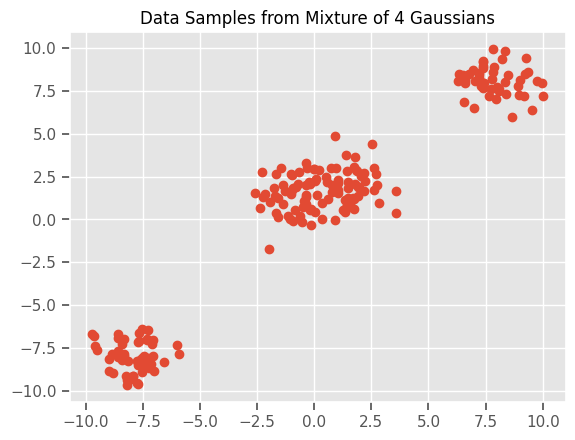

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

data = torch.cat((MultivariateNormal(-8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([1.5, 2]), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([-0.5, 1]), torch.eye(2)).sample([50])))

plt.scatter(data[:, 0], data[:, 1])
plt.title("Data Samples from Mixture of 4 Gaussians")
plt.show()
N = data.shape[0]

In [31]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

In [32]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(2)), obs=data)

In [36]:
data

tensor([[-8.9890e+00, -8.8655e+00],
        [-8.8647e+00, -7.8415e+00],
        [-7.7217e+00, -9.6283e+00],
        [-8.7970e+00, -8.9827e+00],
        [-7.7498e+00, -9.5303e+00],
        [-7.6781e+00, -6.6366e+00],
        [-7.6991e+00, -7.1557e+00],
        [-8.3966e+00, -8.2242e+00],
        [-7.3793e+00, -8.5597e+00],
        [-8.1813e+00, -9.3463e+00],
        [-7.6647e+00, -7.0775e+00],
        [-7.0219e+00, -8.8228e+00],
        [-8.5781e+00, -6.8998e+00],
        [-7.9311e+00, -9.1468e+00],
        [-8.2529e+00, -9.1661e+00],
        [-8.2044e+00, -9.6662e+00],
        [-7.2691e+00, -8.1142e+00],
        [-8.3212e+00, -7.8292e+00],
        [-8.9895e+00, -8.1751e+00],
        [-7.7538e+00, -8.2882e+00],
        [-7.1575e+00, -8.4447e+00],
        [-7.5299e+00, -6.3686e+00],
        [-8.6067e+00, -6.7036e+00],
        [-9.7126e+00, -6.6990e+00],
        [-8.3444e+00, -7.9853e+00],
        [-8.0205e+00, -9.3237e+00],
        [-8.3411e+00, -6.9827e+00],
        [-7.6372e+00, -8.189

In [45]:
def mix_weights2(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    # Replace PyTorch's F.pad with JAX's equivalent padding operations
    beta_padded = jnp.pad(beta, (0, 1), constant_values=1)
    beta1m_cumprod_padded = jnp.pad(beta1m_cumprod, (1, 0), constant_values=1)
    return beta_padded * beta1m_cumprod_padded

In [46]:
import numpyro
def model2(data):
    with numpyro.plate("beta_plate", T-1):
        beta = numpyro.sample("beta", numpyro.distributions.Beta(1, alpha))

    with numpyro.plate("mu_plate", T):
        mu = numpyro.sample("mu", numpyro.distributions.MultivariateNormal(jnp.zeros(2), 5 * jnp.eye(2)))

    with numpyro.plate("data", N):
        z = numpyro.sample("z", numpyro.distributions.Categorical(mix_weights2(beta)))
        numpyro.sample("obs", numpyro.distributions.MultivariateNormal(mu[z], jnp.eye(2)), obs=data)

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = jax.random.PRNGKey(0)
rng_key, rng_key_ = jax.random.split(rng_key)

# Run NUTS.
kernel = NUTS(model2)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run( rng_key_, data=jnp.array(data))
mcmc.print_summary()
samples_1 = mcmc.get_samples()



/tmp/ipykernel_44764/4185311172.py:21: FutureWarning: Some algorithms will automatically enumerate the discrete latent site z of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  mcmc.run( rng_key_, data=jnp.array(data))
sample: 100%|██████████| 3000/3000 [00:04<00:00, 741.32it/s, 31 steps of size 9.60e-02. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.16      0.09      0.18      0.00      0.27    438.46      1.00
   beta[1]      0.17      0.11      0.18      0.00      0.31    335.66      1.00
   beta[2]      0.37      0.07      0.36      0.26      0.49    353.86      1.00
   beta[3]      0.18      0.15      0.13      0.00      0.41    404.09      1.00
   beta[4]      0.71      0.17      0.70      0.48      0.98    199.14      1.00
   mu[0,0]      0.34      1.24      0.56     -1.26      1.90    109.70      1.00
   mu[0,1]      1.55      0.84      1.69      0.49      2.71    306.99      1.00
   mu[1,0]      0.22      1.26     -0.04     -1.34      1.94    209.06      1.01
   mu[1,1]      1.48      0.97      1.60      0.23      2.75    515.57      1.00
   mu[2,0]      7.83      0.14      7.83      7.58      8.05   1932.50      1.00
   mu[2,1]      8.07      0.15      8.07      7.83      8.31   1939.46      1.00
   mu[3,0]      0.09      1

In [33]:
def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))

100%|██████████| 1000/1000 [00:04<00:00, 245.49it/s]


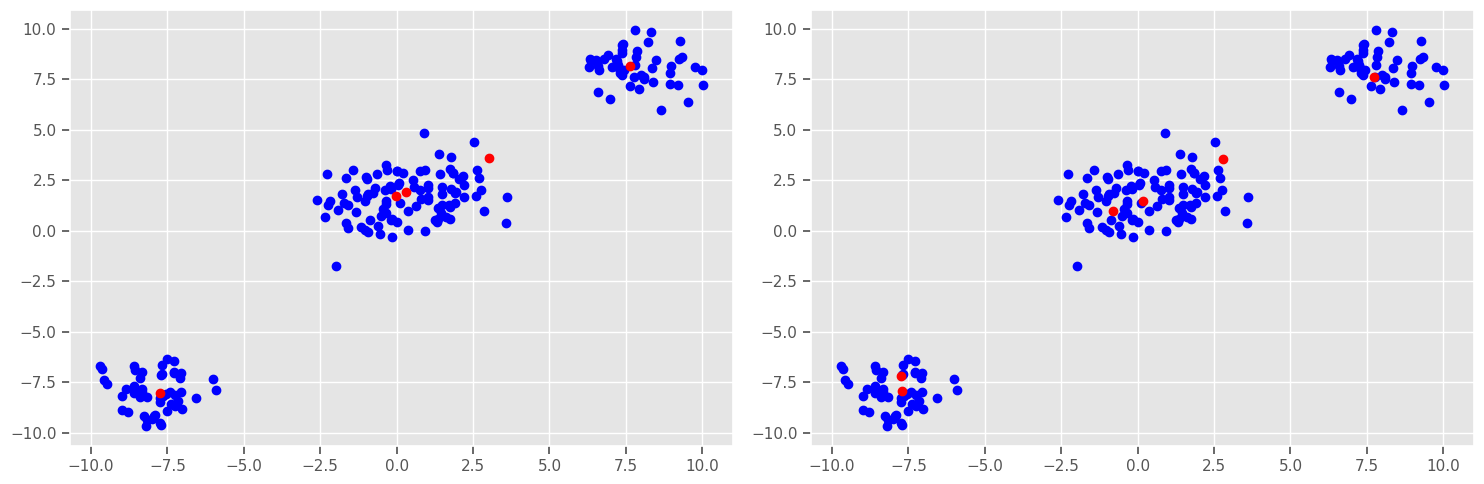

In [34]:
T = 6
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

alpha = 0.1
train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

alpha = 1.5
train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], color="red")

plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1], color="red")
plt.tight_layout()
plt.show()